## Introduction

Let's try repeated 10-fold cross-validation to examine how functional linear regression does!

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle

import skfda
from skfda.misc.operators import LinearDifferentialOperator
from skfda.misc.regularization import L2Regularization
from skfda.ml.regression import LinearRegression as FLinearRegression
from skfda.representation.basis import BSplineBasis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

from tecatorfda.ols_models import (
    plot_and_save_ols_ridge_cv_boxplots,
)
from tecatorfda.data import load_tecator_fat

## Load the fetched/processed data

In [2]:
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat()

fat = fat_df.values.flatten()

N = tecator_df.shape[0]
n = tecator_df.shape[1]

print(f"Number of samples: N={N}")
print(f"Number of observations per sample: n={n}")

Number of samples: N=215
Number of observations per sample: n=100


## Fetch the data in FDataGrid form

In [3]:
tecator_fdatagrid, y_fdatagrid = skfda.datasets.fetch_tecator(return_X_y=True, as_frame=False)

# From my book replication notebook

## Visualize the absorbance data

We plot each absorbance curve and color based on fat content.

In [4]:
norm = matplotlib.colors.Normalize(
    vmin=fat.min(),
    vmax=fat.max()
)

# Each climate is assigned a color. Defaults to grey.
colormap = matplotlib.colormaps['seismic']
curve_colors = colormap(norm(fat))

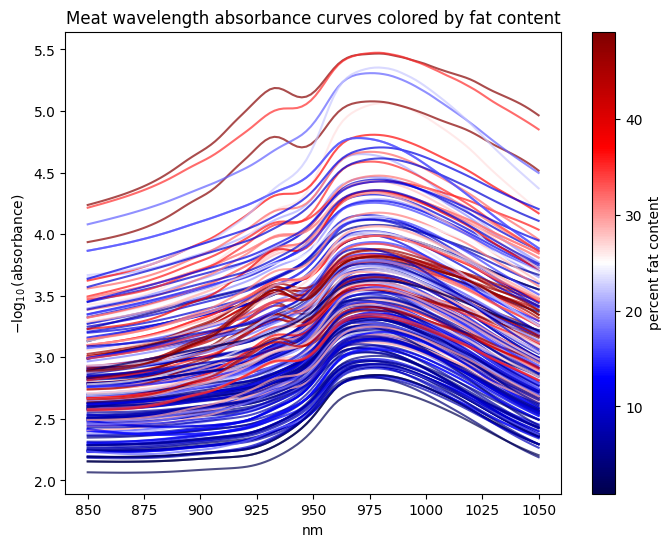

In [5]:
from matplotlib.cm import ScalarMappable

# --- Plot each temperature curve individually ---
plt.figure(figsize=(8, 6))
ax = plt.gca()

for i in range(tecator_df.shape[0]):
    plt.plot(
        wavelength_grid,
        tecator_df.iloc[i],
        color=curve_colors[i],
        alpha=0.7
    )

plt.xlabel(wavelength_unit)
plt.ylabel(r"$-\log_{10}(\text{absorbance})$")
plt.title("Meat wavelength absorbance curves colored by fat content")

# --- Colorbar ---
sm = ScalarMappable(norm=norm, cmap=colormap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("percent fat content")

plt.show()

## Visualize fat content distribution

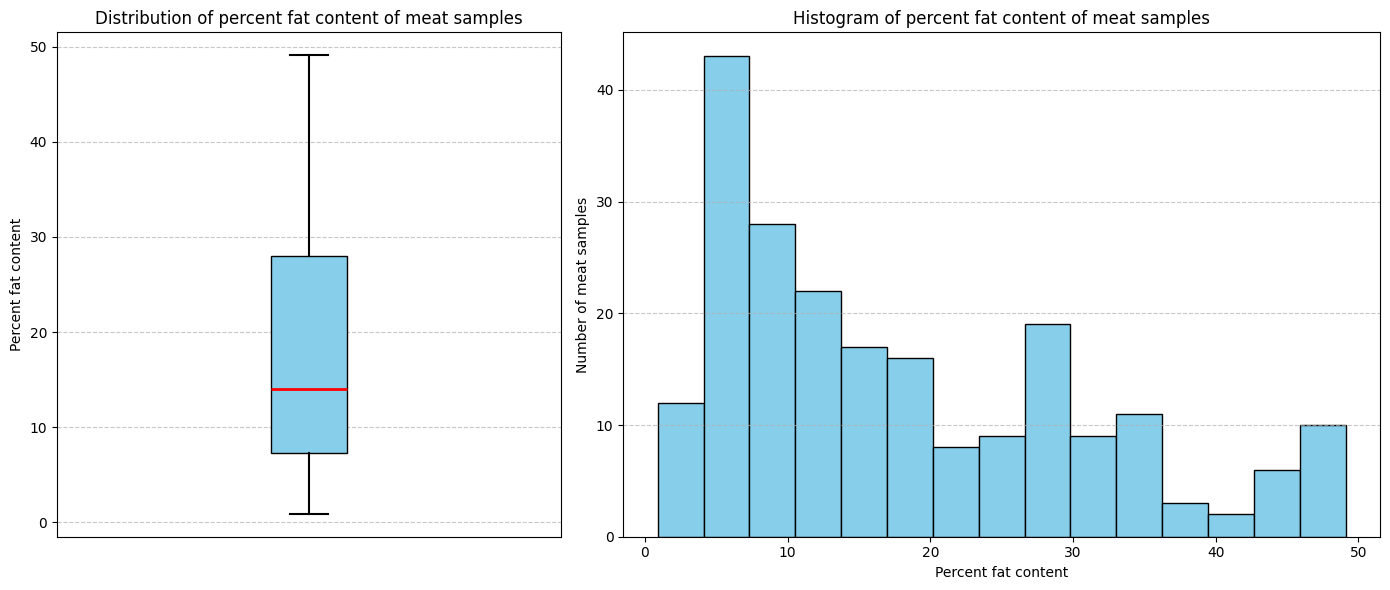

In [6]:
# --- Boxplot + Histogram Side by Side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.5]})

# --- Boxplot (unchanged) ---
axes[0].boxplot(fat, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='orange', markersize=6, linestyle='none'))

axes[0].set_ylabel("Percent fat content")
axes[0].set_title("Distribution of percent fat content of meat samples")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_xticks([])

# --- Histogram ---
axes[1].hist(fat, bins=15, color='skyblue', edgecolor='black')
axes[1].set_xlabel("Percent fat content")
axes[1].set_ylabel("Number of meat samples")
axes[1].set_title("Histogram of percent fat content of meat samples")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Helpers from other FLR notebook

### Matrix formation

In [25]:
def matrix_formation(fdatagrid, K_X, K_beta):
    # Form the X basis and coefficients.
    X_basis = skfda.representation.basis.BSplineBasis(n_basis=K_X)
    X_basis_representation = fdatagrid.to_basis(X_basis)

    # Form the beta basis.
    beta_basis = skfda.representation.basis.BSplineBasis(n_basis=K_beta)

    # Compute the K_X x K_beta L2 inner product matrix J.
    J = X_basis.inner_product_matrix(beta_basis)

    # Construct the matrix Z by prepending a column of ones.
    Z = np.concatenate((np.ones((fdatagrid.data_matrix.shape[0], 1)), X_basis_representation.coefficients @ J), axis=1)

    # Form the penalty matrix R. From ChatGPT.
    I = np.eye(K_beta)
    deriv_basis, C = beta_basis.derivative_basis_and_coefs(I, order=2)
    G = deriv_basis.gram_matrix()
    R = C @ G @ C.T
    R_0 = np.concatenate((np.zeros((K_beta, 1)), R), axis=1)
    R_0 = np.concatenate((np.zeros((1, K_beta+1)), R_0), axis=0)

    return X_basis, X_basis_representation, beta_basis, J, Z, R_0

### Evaluation function

In [17]:
def coef_computation_and_metric_evaluation(lam, Z, R_0, y, verbose=False):
    # Easy, reused computations.
    SS_tot = np.sum((y - y.mean())**2)
    A = Z.T @ Z + lam * R_0

    # Beta basis coefficients.
    zeta_hat = np.linalg.solve(A, Z.T @ y)

    # Hat matrix. TODO: maybe follow ChatGPT's advice of not actually computing this n x n matrix.
    S = Z @ np.linalg.solve(A, Z.T)

    # Degrees of freedom.
    df = np.trace(S)

    # Overall R^2.
    y_hat = S @ y
    y_res = y - y_hat
    SS_res = np.sum(y_res**2)
    R2 = 1 - SS_res / SS_tot

    # LOOCV score and Predictive R^2.
    S_diag = np.diag(S)
    y_del_res = y_res / (1 - S_diag + 1e-6)
    CV_score = (y_del_res**2).sum()
    R2_pred = 1 - CV_score / SS_tot

    # Compute confidence limits.
    sigma2e = SS_res / (y.shape[0] - df)
    # We need to compute A^{-1} Z' Z A^{-1}.
    # We could use sigma2e * np.linalg.solve(A, np.linalg.solve(A, Z.T @ Z)), but
    # oftentimes this loses symmetry and positive semi-definiteness. So, ChatGPT
    # recommended this.
    U = np.linalg.solve(A, Z.T)
    var_zeta = sigma2e * (U @ U.T)
    var_zeta = 0.5 * (var_zeta + var_zeta.T)
    var_zeta = var_zeta[1:, 1:]

    if verbose:
        print("Degrees of freedom:", round(df, 1))
        print()
        print("R^2:", round(R2, 2))
        print("Predictive R^2:", round(R2_pred, 2))
        print("CV score:", round(CV_score, 1))

    return zeta_hat, var_zeta, df, R2, R2_pred, CV_score

## Minimal helpers from ChatGPT

### Fit $\zeta$ on train, predict $y$ on test

In [7]:
def fit_zeta(lam, Z_train, R0, y_train):
    A = Z_train.T @ Z_train + lam * R0
    return np.linalg.solve(A, Z_train.T @ y_train)

def predict_from_zeta(Z_test, zeta_hat):
    return Z_test @ zeta_hat

### Build $Z$ for a subset

In [23]:
def build_Z_R0(fdatagrid_subset, K_X, K_beta):
    _, _, _, _, Z, R_0 = matrix_formation(fdatagrid_subset, K_X=K_X, K_beta=K_beta)
    return Z, R_0

### Inner selection of $\lambda$

In [18]:
def select_lambda_by_loocv(lam_grid, Z_train, R0, y_train):
    best_lam, best_cv = None, np.inf
    for lam in lam_grid:
        _, _, _, _, _, cv = coef_computation_and_metric_evaluation(lam, Z_train, R0, y_train, verbose=False)
        if cv < best_cv:
            best_cv, best_lam = cv, lam
    return best_lam


### Outer repeated 10-fold CV loop ($R^{2}$ on held-out fold)

In [19]:
def repeated_cv_flr(
    tecator_fdatagrid,
    y,
    K_X,
    K_beta,
    lam_grid,
    random_state=0,
):
    y = np.asarray(y).ravel()
    outer = RepeatedKFold(n_splits=10, n_repeats=10, random_state=random_state)

    outer_scores = []
    chosen_lams = []

    for train_idx, test_idx in outer.split(np.arange(len(y))):
        # Build Z, R0 on train and test
        Z_train, R0 = build_Z_R0(tecator_fdatagrid[train_idx], K_X, K_beta)
        Z_test, _  = build_Z_R0(tecator_fdatagrid[test_idx],  K_X, K_beta)  # same K's, no need for R0 here

        y_train, y_test = y[train_idx], y[test_idx]

        # Inner tuning on training fold
        lam_star = select_lambda_by_loocv(lam_grid, Z_train, R0, y_train)
        chosen_lams.append(lam_star)

        # Fit on training fold with chosen lambda
        zeta_hat = fit_zeta(lam_star, Z_train, R0, y_train)

        # Predict and score on test fold
        y_hat = predict_from_zeta(Z_test, zeta_hat)
        ss_res = np.sum((y_test - y_hat) ** 2)
        ss_tot = np.sum((y_test - y_test.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot

        outer_scores.append(r2)

    return np.array(outer_scores), np.array(chosen_lams)


In [27]:
data_path = Path(os.getcwd()) / "03_flr"
data_path.mkdir(parents=True, exist_ok=True)

results_file = data_path / "repeated_cv_results.pkl"

if not results_file.exists():
    lam_grid = 10 ** np.arange(-16, -6, 1.)   # adjust after a pilot
    K_X = 30
    K_beta = 30

    scores, chosen_lams = repeated_cv_flr(
        tecator_fdatagrid=tecator_fdatagrid,
        y=fat,
        K_X=K_X,
        K_beta=K_beta,
        lam_grid=lam_grid,
        random_state=0,
    )

    with open(results_file, "wb") as f:
        pickle.dump(
            {"scores": scores, "chosen_lams": chosen_lams, "K_X": K_X, "K_beta": K_beta, "lam_grid": lam_grid},
            f,
        )
else:
    with open(results_file, "rb") as f:
        obj = pickle.load(f)
    scores = obj["scores"]

print("FLR mean R^2:", scores.mean())
print("FLR std R^2:", scores.std())

FLR mean R^2: 0.9574284181835008
FLR std R^2: 0.02218295433605442
